### Evaluation Activity 2: Image processing
Team members:
- Rogelio Novelo
- Carlos Helguera
- Francisco Chan

**This notebook was made in Collab.**

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [ ]:
%pip install cython

#### Loading image

In [ ]:
image = Image.open('/content/starry.jpg')
gray_image = image.convert("L")

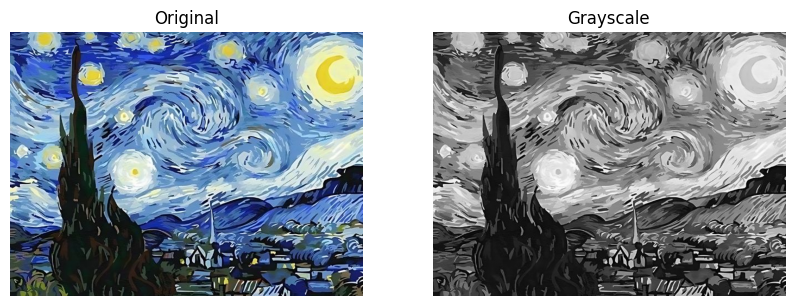

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(gray_image, cmap="gray")
plt.title("Grayscale")
plt.axis("off")

plt.show()

### Gaussian Filter

#### Pure python

In [ ]:
def apply_gaussian_filter(image_list, width, height):
    kernel = [[1, 2, 1],
              [2, 4, 2],
              [1, 2, 1]]
    kernel_sum = 16

    filtered_image = [[0] * width for _ in range(height)]

    for y in range(1, height - 1):
        for x in range(1, width - 1):
            sum_pixels = 0

            for ky in range(-1, 2):
                for kx in range(-1, 2):
                    sum_pixels += image_list[y + ky][x + kx] * kernel[ky + 1][kx + 1]

            filtered_image[y][x] = min(255, max(0, sum_pixels // kernel_sum))

    return filtered_image

def image_to_list(image):
    width, height = image.size
    image_list = [[image.getpixel((x, y)) for x in range(width)] for y in range(height)]
    return image_list, width, height

def list_to_image(image_list, width, height):
    output_image = Image.new("L", (width, height))
    for y in range(height):
        for x in range(width):
            output_image.putpixel((x, y), image_list[y][x])
    return output_image

In [ ]:
def main(input_path, output_path):
    # Open image and convert to grayscale
    image = Image.open(input_path).convert("L")
    image_list, width, height = image_to_list(image)

    # Apply Gaussian filter
    start_time = time.time()
    filtered_image_list = apply_gaussian_filter(image_list, width, height)
    end_time = time.time()
    execution_time = end_time - start_time

    # Convert list back to image and save
    filtered_image = list_to_image(filtered_image_list, width, height)
    filtered_image.save(output_path)
    print("Filtered image saved as", output_path)
    return execution_time

In [142]:
# Example usage
if __name__ == "__main__":
   time_gauss_filter =  main("starry.jpg", "output_gauss.jpg")
   print(f"Execution time: {time_gauss_filter} seconds")

Filtered image saved as output_gauss.jpg
Execution time: 2.1033926010131836 seconds


#### Numpy

In [159]:
def apply_gaussian_filter(image_array):
    # 3x3 Gaussian kernel with sigma = 1
    kernel = np.array([[1, 2, 1],
                        [2, 4, 2],
                        [1, 2, 1]], dtype=np.float64) / 16

    # Pad the image with zeros to handle borders
    padded_image = np.pad(image_array, pad_width=1, mode='constant', constant_values=0)

    # Apply filter using NumPy's convolution operation
    filtered_image = np.zeros_like(image_array, dtype=np.uint8)

    # Extract 3x3 patches using NumPy's stride tricks
    shape = (image_array.shape[0], image_array.shape[1], 3, 3)
    strides = padded_image.strides + padded_image.strides
    patches = np.lib.stride_tricks.as_strided(padded_image, shape=shape, strides=strides)

    # Apply convolution in a vectorized way
    filtered_image = np.tensordot(patches, kernel, axes=((2, 3), (0, 1))).astype(np.uint8)

    return filtered_image


In [160]:
input_path = "starry.jpg"
image = Image.open(input_path).convert("L")
image_array = np.array(image, dtype=np.uint8)

In [161]:
start_time = time.time()
filtered_image_array = apply_gaussian_filter(image_array)
end_time = time.time()
time_gauss_numpy = end_time - start_time

In [162]:
print(f"Execution time: {time_gauss_numpy}")

Execution time: 0.03617358207702637


### Cython

In [ ]:
%%writefile gauss_cython.pyx
import numpy as np
cimport numpy as np
from scipy.ndimage import convolve
from scipy.ndimage import median_filter
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
def gaussian_cython(np.ndarray[np.uint8_t, ndim=2] image_array):
    cdef np.ndarray[np.float64_t, ndim=2] kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=np.float64) / 16.0
    cdef np.ndarray[np.uint8_t, ndim=2] result = convolve(image_array, kernel, mode='reflect')
    return result

Overwriting gauss_cython.pyx


In [164]:
# Open image and convert to grayscale
image = Image.open('starry.jpg').convert("L")
image_array = np.array(image, dtype=np.uint8)

In [165]:
# Apply Gaussian filter
start_time = time.time()
filtered_image_array = apply_gaussian_filter(image_array)
end_time = time.time()
cython_ex_time = end_time - start_time

In [166]:
print(f"Execution time: {cython_ex_time} seconds")

Execution time: 0.02890753746032715 seconds


#### Execution times

In [167]:
# Create dataframes with the times
df_gauss = pd.DataFrame({
    "Version": ["Pure Python", "NumPy", "NumPy + Cython"],
    "Execution_time (s)": [time_gauss_filter, time_gauss_numpy, cython_ex_time]
})

# Show table
print(df_gauss)

          Version  Execution_time (s)
0     Pure Python            2.103393
1           NumPy            0.036174
2  NumPy + Cython            0.028908


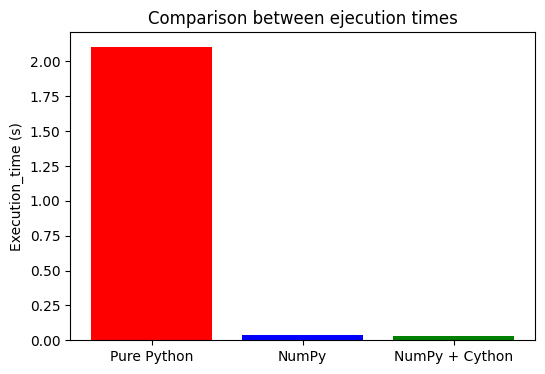

In [168]:
# Graphic ejecution times
plt.figure(figsize=(6,4))
plt.bar(df_gauss["Version"], df_gauss["Execution_time (s)"], color=["red", "blue", "green"])
plt.ylabel("Execution_time (s)")
plt.title("Comparison between ejecution times")
plt.show()

#### Result

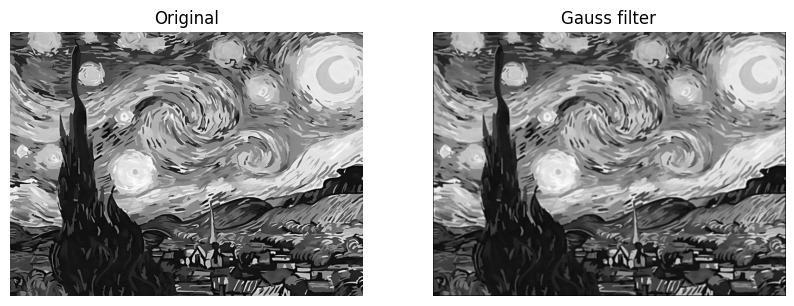

In [138]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.title("Original")
plt.axis("off")

image_gauss = Image.open('output_gauss.jpg')
plt.subplot(1, 2, 2)
plt.imshow(image_gauss, cmap="gray")
plt.title("Gauss filter")
plt.axis("off")

plt.show()

### Sobel filter

In [ ]:
# Charge the image using a grey scale
image = cv2.imread("starry.jpg", cv2.IMREAD_GRAYSCALE)

# Verify if the image was uploaded correctly
if image is None:
    raise ValueError("The image could not be loaded. Make sure the 'poster.jpg' file exists.")

#### Pure python

In [ ]:
def sobel_filter_python(image):
    height, width = image.shape
    Gx = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
    Gy = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]

    gradient_magnitude = np.zeros((height, width))

    for i in range(1, height-1):
        for j in range(1, width-1):
            gx = sum(image[i+k-1, j+l-1] * Gx[k][l] for k in range(3) for l in range(3))
            gy = sum(image[i+k-1, j+l-1] * Gy[k][l] for k in range(3) for l in range(3))
            gradient_magnitude[i, j] = (gx**2 + gy**2) ** 0.5

    return gradient_magnitude.astype(np.uint8)

In [ ]:
# Measure execution time
start_time = time.time()
edge_python = sobel_filter_python(image)
python_time = time.time() - start_time

In [174]:
def save_sobel_filtered_image(filtered_image, output_path):

    # Convert the NumPy array to a PIL image
    image = Image.fromarray(filtered_image)

    # Save the image
    image.save(output_path)
    print(f"Filtered image saved to {output_path}")


save_sobel_filtered_image(edge_python, "sobel_output.jpg")

Filtered image saved to sobel_output.jpg



#### Numpy

In [ ]:
def sobel_filter_numpy(image):
    Gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Gy = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    grad_x = cv2.filter2D(image, -1, Gx)
    grad_y = cv2.filter2D(image, -1, Gy)

    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    return np.uint8(gradient_magnitude)

# Measure execution time
start_time = time.time()
edge_numpy = sobel_filter_numpy(image)
numpy_time = time.time() - start_time

In [ ]:
# Measure execution time
start_time = time.time()
edge_numpy = sobel_filter_numpy(image)
numpy_time = time.time() - start_time


#### Cython

In [ ]:
%load_ext cython

In [ ]:
%%cython
import numpy as np
cimport numpy as np
from libc.math cimport sqrt

# Definir función optimizada en Cython
def sobel_filter_cython(np.ndarray[np.uint8_t, ndim=2] image):
    cdef int height = image.shape[0]
    cdef int width = image.shape[1]

    cdef int Gx[3][3]
    cdef int Gy[3][3]

    Gx = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
    Gy = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]

    cdef np.ndarray[np.float64_t, ndim=2] gradient_magnitude = np.zeros((height, width), dtype=np.float64)

    cdef int i, j, k, l
    cdef int gx, gy

    # Apply sobel filter
    for i in range(1, height-1):
        for j in range(1, width-1):
            gx = 0
            gy = 0
            for k in range(3):
                for l in range(3):
                    gx += image[i+k-1, j+l-1] * Gx[k][l]
                    gy += image[i+k-1, j+l-1] * Gy[k][l]
            gradient_magnitude[i, j] = sqrt(gx**2 + gy**2)

    # Convert to uint8 before returning result
    return np.uint8(gradient_magnitude)

Content of stderr:
In file included from /usr/local/lib/python3.11/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /usr/local/lib/python3.11/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.11/dist-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /root/.cache/ipython/cython/_cython_magic_624bb2b498be9c05adf3e88d3b2867d2622c3607.c:1250:
/usr/local/lib/python3.11/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~

In [ ]:
# Upload image (make sure you set "image" correctly)
image = np.array(Image.open("starry.jpg").convert("L"))  # Convert into a grey scale

In [ ]:
# Medir tiempo de ejecución
start_time = time.time()
edge_cython = sobel_filter_cython(image)
cython_time = time.time() - start_time

#### Execution times

In [130]:
# Crear DataFrame con los tiempos
df = pd.DataFrame({
    "Método": ["Pure Python", "NumPy", "NumPy + Cython"],
    "Tiempo de ejecución (s)": [python_time, numpy_time, cython_time]
})

# Mostrar tabla
print(df)

           Método  Tiempo de ejecución (s)
0     Pure Python                14.393055
1           NumPy                 0.016165
2  NumPy + Cython                 0.009896


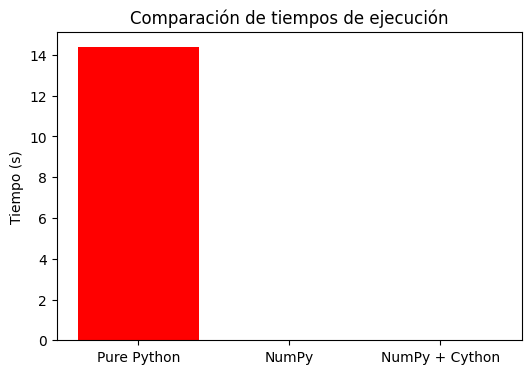

In [132]:
# Graficar comparación de tiempos
plt.figure(figsize=(6,4))
plt.bar(df["Método"], df["Tiempo de ejecución (s)"], color=["red", "blue", "green"])
plt.ylabel("Tiempo (s)")
plt.title("Comparación de tiempos de ejecución")
plt.show()

#### Result

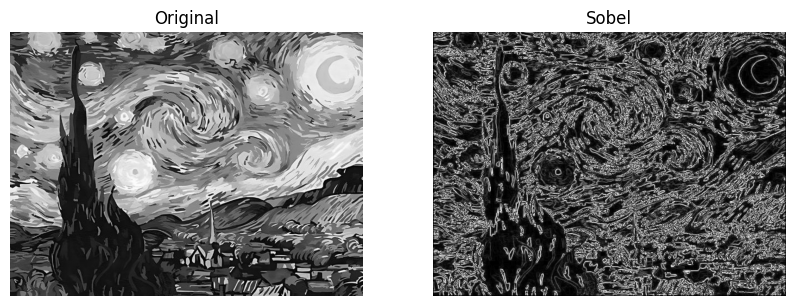

In [139]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(edge_cython, cmap='gray')
plt.title(f"Sobel")
plt.axis("off")

plt.show()

### Median Filter

In [119]:
# Si prefieres, puedes usar una imagen "ejemplo" generada aleatoriamente o un archivo local:
image_path = "starry.jpg"
image = Image.open(image_path)

# Convertimos la imagen a escala de grises (si fuese a color)
gray_image = image.convert("L")
img_array = np.array(gray_image)

#### Pure Python

In [120]:
def median_filter_python(input_image):
    """
    Aplica un filtro de mediana 3x3 sobre 'input_image' (lista de listas)
    usando Python puro (sin NumPy). Se asume escala de grises [0..255].
    """
    # input_image: lista de listas, dimensión [alto][ancho]
    h = len(input_image)
    w = len(input_image[0])

    # Salida inicializada en ceros
    output = [[0]*w for _ in range(h)]

    # Para manejar bordes: replicamos la primera y última fila/columna
    # y así acceder sin salirnos de rango (padding)
    def get_pixel(i, j):
        # Ajustamos índices si están en el borde
        if i < 0: i = 0
        if i >= h: i = h - 1
        if j < 0: j = 0
        if j >= w: j = w - 1
        return input_image[i][j]

    # Recorremos cada píxel
    for y in range(h):
        for x in range(w):
            # Tomamos la vecindad 3x3
            window = []
            for dy in [-1, 0, 1]:
                for dx in [-1, 0, 1]:
                    window.append(get_pixel(y+dy, x+dx))
            # Ordenamos y tomamos la mediana
            window.sort()
            med_val = window[4]  # valor central en 3x3
            output[y][x] = med_val

    return output

#### Numpy

In [121]:
def median_filter_numpy(input_array):
    """
    Applies a 3x3 median filter using NumPy / scipy.
    Assumes that 'input_array' is a NumPy 2D (grayscale) array.
    """
    from scipy.ndimage import median_filter
    # size=3 -> ventana 3x3
    result = median_filter(input_array, size=3, mode='nearest')
    return result

#### Cython

In [ ]:
%%writefile cython_median.pyx
import numpy as np
cimport numpy as np
from scipy.ndimage import convolve
from scipy.ndimage import median_filter
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
def median_cython(np.ndarray[np.uint8_t, ndim=2] image_array):
    cdef np.ndarray[np.uint8_t, ndim=2] result = median_filter(image_array, size=3, mode='reflect')
    return result

Writing cython_median.pyx


#### Execution time

In [122]:
def measure_time(func, img, version_name, is_numpy=False):
    """
Measures execution time of the 'func' function that applies the median filter.
'img' can be list of lists (pure python) or NumPy array (numpy/cython).
    """
    start = time.time()
    result = func(img)
    end = time.time()
    elapsed = end - start
    return {
        "Version": version_name,
        "Time (s)": elapsed,
        "Result": result
    }

In [169]:
from cython_median import median_cython

# Preparamos la imagen como lista de listas para la versión Python puro
image_list_of_lists = img_array.tolist()  # conv NumPy -> lista de listas

# 1) Python puro
t1 = measure_time(median_filter_python, image_list_of_lists, "Python Puro")

# 2) NumPy
t2 = measure_time(median_filter_numpy, img_array, "NumPy", True)

# 3) NumPy + Cython
t3 = measure_time(median_cython, img_array, "Cython", True)

# Creamos una DataFrame para tabular los tiempos
results_df = pd.DataFrame([t1, t2, t3])[["Version", "Time (s)"]]
print(results_df)

       Version  Time (s)
0  Python Puro  2.146440
1        NumPy  0.062448
2       Cython  0.052140


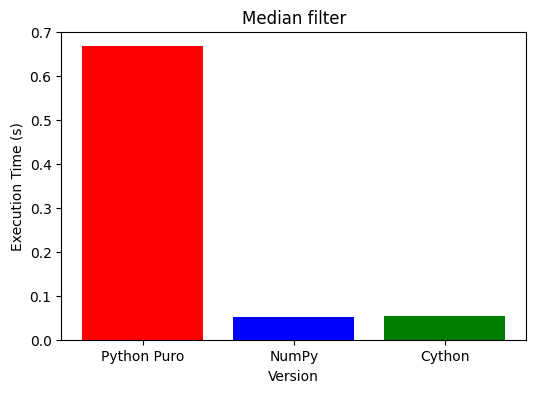

In [141]:
plt.figure(figsize=(6,4))
plt.bar(results_df["Version"], results_df["Time (s)"], color=["red", "blue", "green"])
plt.xlabel("Version")
plt.ylabel("Execution Time (s)")
plt.title("Median filter")
plt.show()

#### Result

In [175]:
def transform_to_image(filtered_array, output_path=None):

    # Convert the filtered array to an image
    image = Image.fromarray(filtered_array.astype(np.uint8))

    # Save the image if an output path is provided
    if output_path:
        image.save(output_path)
        print(f"Image saved to {output_path}")

    return image


median_result = transform_to_image(t2['Result'], 'median_output.jpg')

Image saved to median_output.jpg


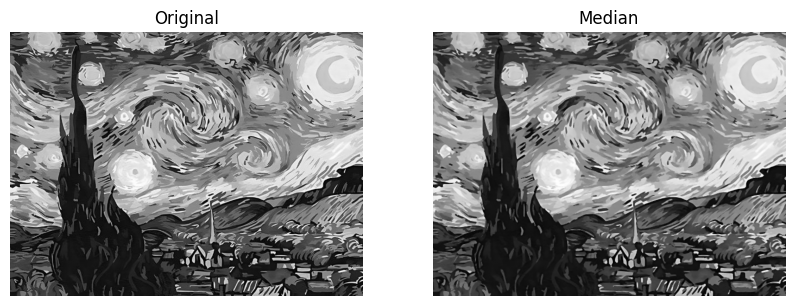

In [140]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(median_result, cmap='gray')
plt.title(f"Median")
plt.axis("off")

plt.show()

### Scripts used for Cython implementations

In [ ]:
%%writefile setup.py
from distutils.core import setup
from Cython.Build import cythonize
import numpy

setup(
    ext_modules = cythonize("cython_median.pyx"),
    include_dirs=[numpy.get_include()]
)

Overwriting setup.py


In [ ]:
!python setup.py build_ext --inplace

Compiling cython_median.pyx because it changed.
[1/1] Cythonizing cython_median.pyx
/usr/local/lib/python3.11/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/cython_median.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
In file included from /usr/local/lib/python3.11/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /usr/local/lib/python3.11/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.11/dist-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from cython_median.c:1240:
/usr/local/lib/python3.11/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.htm

In [170]:
!pip freeze > requirements.txt

In [171]:
# Step 3: Download the requirements.txt file
from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>